# Chapter 2: Taking Earth's Temperature

### PART III: Visualising recent temperatre anomalies<a class="anchor" id="chapter-one"></a>

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-cams/master?labpath=vis-animations.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-cams/blob/master/vis-animations.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-cams/blob/master/vis-animations.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

In [1]:
# Python Standard Libraries
import os
import datetime as dt
import calendar
from string import ascii_lowercase as ABC

# Data Manipulation Libraries
import numpy as np
import pandas as pd
import xarray as xr
import dask

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import cartopy.crs as ccrs
from dask.diagnostics.progress import ProgressBar

# Climate Data Store API for retrieving climate data
import cdsapi


In [2]:
plt.style.use(
    "../copernicus.mplstyle"
)  # Set the visual style of the plots; not necessary for the tutorial

In [3]:
dask.config.set(**{"array.slicing.split_large_chunks": True})

In [4]:
# Define regions of interest
# =============================================================================
# Some regions are defined here: https://climate.copernicus.eu/esotc/2022/about-data#Regiondefinitions
REGIONS = {
    "Global": {"lon": slice(-180, 180), "lat": slice(-90, 90)},
    "Northern Hemisphere": {"lon": slice(-180, 180), "lat": slice(0, 90)},
    "Southern Hemisphere": {"lon": slice(-180, 180), "lat": slice(-90, 0)},
    "Europe": {"lon": slice(-25, 40), "lat": slice(34, 72)},
    "Arctic": {"lon": slice(-180, 180), "lat": slice(66.6, 90)},
}


In [5]:
# Define some parameters that can be easily changed
PROJS = {
    "Europe": ccrs.TransverseMercator(central_longitude=15, central_latitude=52),
    "Arctic": ccrs.Orthographic(central_longitude=0, central_latitude=90),
    "Global": ccrs.EqualEarth(),
    "Data": ccrs.PlateCarree(),
}

In [6]:
# Define climatology period
# =============================================================================
REF_PERIOD = {"time": slice("1991", "2020")}

In [7]:
file_name = {}  # dictionary containing [data source : file name]

# Add the data sources and file names
file_name.update({"era5": "temperature_era5.nc"})

# Create the paths to the files
path_to = {
    source: os.path.join(f"data/{source}/", file) for source, file in file_name.items()
}

# Create necessary directories if they do not exist
for path in path_to.values():
    os.makedirs(
        os.path.dirname(path), exist_ok=True
    )  # create the folder if not available

path_to

{'era5': 'data/era5/temperature_era5.nc'}

In [8]:
def coordinate_is_monthly(ds, coord: str = "time"):
    """Return True if the coordinates are months"""
    time_diffs = np.diff(ds.coords[coord].values)
    time_diffs = pd.to_timedelta(time_diffs).days

    # If all differences are between 28 and 31 days
    if np.all((28 <= time_diffs) & (time_diffs <= 31)):
        return True
    else:
        return False


def streamline_coords(da):
    """Streamline the coordinates of a DataArray.

    Parameters
    ----------
    da : xr.DataArray
        The DataArray to streamline.
    """

    # Ensure that time coordinate is fixed to the first day of the month
    if "time" in da.coords:
        if coordinate_is_monthly(da, "time"):
            da.coords["time"] = da["time"].to_index().to_period("M").to_timestamp()

    # Ensure that spatial coordinates are called 'lon' and 'lat'
    if "longitude" in da.coords:
        da = da.rename({"longitude": "lon"})
    if "latitude" in da.coords:
        da = da.rename({"latitude": "lat"})

    # Ensure that lon/lat are sorted in ascending order
    da = da.sortby("lat")
    da = da.sortby("lon")

    # Ensure that lon is in the range [-180, 180]
    lon_min = da["lon"].min()
    lon_max = da["lon"].max()
    if lon_min < -180 or lon_max > 180:
        da.coords["lon"] = (da.coords["lon"] + 180) % 360 - 180
        da = da.sortby(da.lon)

    return da

In [9]:
def weighted_spatial_average(da, region, land_mask=None):
    """Calculate the weighted spatial average of a DataArray.

    Parameters
    ----------
    da : xr.DataArray
        The DataArray to average.
    weights : xr.DataArray, optional
        A DataArray with the same dimensions as `da` containing the weights.
    """
    da = da.sel(**region)

    # Area weighting: calculate the area of each grid cell
    weights = np.cos(np.deg2rad(da.lat))

    # Additional user-specified weights, e.g. land-sea mask
    if land_mask is not None:
        land_mask = land_mask.sel(**region)
        weights = weights * land_mask.fillna(0)

    return da.weighted(weights).mean(("lat", "lon"))

##### ERA5 reanalysis

Now, let's retrieve our data from the CDS using the `cdsapi.Client()`. Here, we download the reanalysis ERA5 single levels monthly means data for the variable '2m_temperature' from 1950 to 2022.

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    For efficiency and to expedite processing time, we are opting to download the data at a coarser resolution of 1x1 degree, as opposed to the highest (default) resolution of 0.25x0.25 degree. Please be aware that this could lead to minor discrepancies when compared to figures published in <a href="https://climate.copernicus.eu/climate-bulletins">climate intelligence bulletins.</a>
</div>

<div class="alert alert-block alert-info">
<b>NOTE</b>: <br>
    Please note that the time to request and download the data may vary as it depends on several factors. It typically should take less than 10 minutes though.
</div>

In [ ]:
c = cdsapi.Client()

c.retrieve(
  'reanalysis-era5-single-levels-monthly-means',
  {
    'format': 'netcdf',
    'product_type': 'monthly_averaged_reanalysis',
    'variable': ['2m_temperature', 'land_sea_mask'],
    'year': list(range(1950, 2023)),
    'month': list(range(1, 13)),
    'time': '00:00',
    # 'grid': [0.25, 0.25],
  },
  path_to['era5']
)

2023-07-18 23:37:09,436 INFO Welcome to the CDS
2023-07-18 23:37:09,437 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-07-18 23:37:09,532 INFO Request is queued
2023-07-18 23:37:10,588 INFO Request is running
2023-07-18 23:47:29,182 INFO Request is completed
2023-07-18 23:47:29,184 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data9/adaptor.mars.internal-1689716608.4304297-30290-1-58d02187-6545-4a99-83e3-91816a555a27.nc to data/era5/temperature_era5.nc (3.4G)
2023-07-19 00:26:09,727 INFO Download rate 1.5M/s     


Result(content_length=3638006464,content_type=application/x-netcdf,location=https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data9/adaptor.mars.internal-1689716608.4304297-30290-1-58d02187-6545-4a99-83e3-91816a555a27.nc)

In [10]:
with xr.open_mfdataset(path_to["era5"]) as era5:
    # convert from Kelvin to Celsius
    era5["t2m"] = era5["t2m"] - 273.15
era5 = streamline_coords(era5)
era5_monthly_climatology = era5["t2m"].sel(REF_PERIOD).groupby("time.month").mean()
era5["anom"] = era5["t2m"].groupby("time.month") - era5_monthly_climatology


/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 73 times more chunks
  return self.array[key]


In [11]:
# Compute the most recent anomaly
with ProgressBar():
    era5_in_2022 = era5["anom"].isel(time=-1).compute()


[########################################] | 100% Completed | 78.63 s


In [12]:
levels = np.arange(-6, 6.5, 1)
kwargs = dict(
    levels=levels,
    transform=PROJS["Data"],
    cmap="RdYlBu_r",
    cbar_kwargs=dict(label="Temperature anomaly (ºC)"),
)

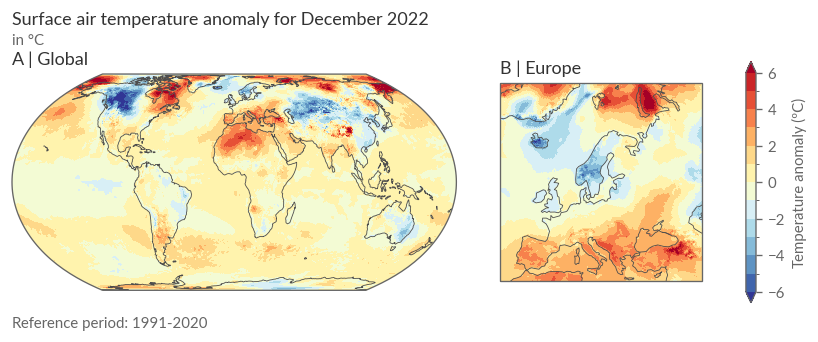

In [20]:
# Create the Monthly Bulletin
fig = plt.figure(figsize=(8, 2.8), dpi=120)
gs = GridSpec(
    3, 3, figure=fig, width_ratios=[2.2, 1, 0.05], height_ratios=[0.05, 1, 0.05]
)

# Add the axes
tax = fig.add_subplot(gs[0, 0])
bax = fig.add_subplot(gs[2, 0])
ax1 = fig.add_subplot(gs[1, 0], projection=PROJS["Global"])
ax2 = fig.add_subplot(gs[1, 1], projection=PROJS["Europe"])
cax = fig.add_subplot(gs[1, 2])

# Set the extent of the maps
ax1.set_global()
ax2.set_extent([-13, 46, 35, 82], crs=PROJS["Data"])

# Add coastlines and anomlies
for ax in [ax1, ax2]:
    ax.coastlines(lw=0.5, color=".3")
    era5_in_2022.plot(ax=ax, cbar_ax=cax, **kwargs)

# Add titles, labels and text
ax1.set_title("A | Global")
ax2.set_title("B | Europe")

month_number = era5_in_2022.time.dt.month.item()
title = f"Surface air temperature anomaly for {calendar.month_name[month_number]} 2022"
tax.set_title(title)
tax.text(0, 0, "in °C", ha="left", va="bottom", transform=tax.transAxes)
tax.axis("off")
bax.axis("off")
ref_start = REF_PERIOD["time"].start
ref_end = REF_PERIOD["time"].stop
bax.text(
    0,
    0,
    f"Reference period: {ref_start}-{ref_end}",
    ha="left",
    va="bottom",
    transform=bax.transAxes,
)
fig.subplots_adjust(bottom=0.0, hspace=0.02)
plt.show()

In [13]:
# Running twelve-month averages of global-mean and European-mean
# surface air temperature anomalies relative to 1991-2020
# -----------------------------------------------------------------------------
era5_satellite = era5["anom"].sel(time=slice("1979", None))
era5_global_mean = weighted_spatial_average(
    era5_satellite, REGIONS["Global"], land_mask=None
)
era5_europe_mean = weighted_spatial_average(
    era5_satellite, REGIONS["Europe"], era5["lsm"]
)
era5_arctic_mean = weighted_spatial_average(
    era5_satellite, REGIONS["Arctic"], era5["lsm"]
)

with ProgressBar():
    era5_global_mean = era5_global_mean.compute()
    era5_europe_mean = era5_europe_mean.compute()
    era5_arctic_mean = era5_arctic_mean.compute()


[########################################] | 100% Completed | 178.85 s
[########################################] | 100% Completed | 147.67 s
[########################################] | 100% Completed | 88.63 s


In [14]:
era5_global_mean_smooth = era5_global_mean.rolling(time=12, center=True).mean()
era5_europe_mean_smooth = era5_europe_mean.rolling(time=12, center=True).mean()
era5_arctic_mean_smooth = era5_arctic_mean.rolling(time=12, center=True).mean()

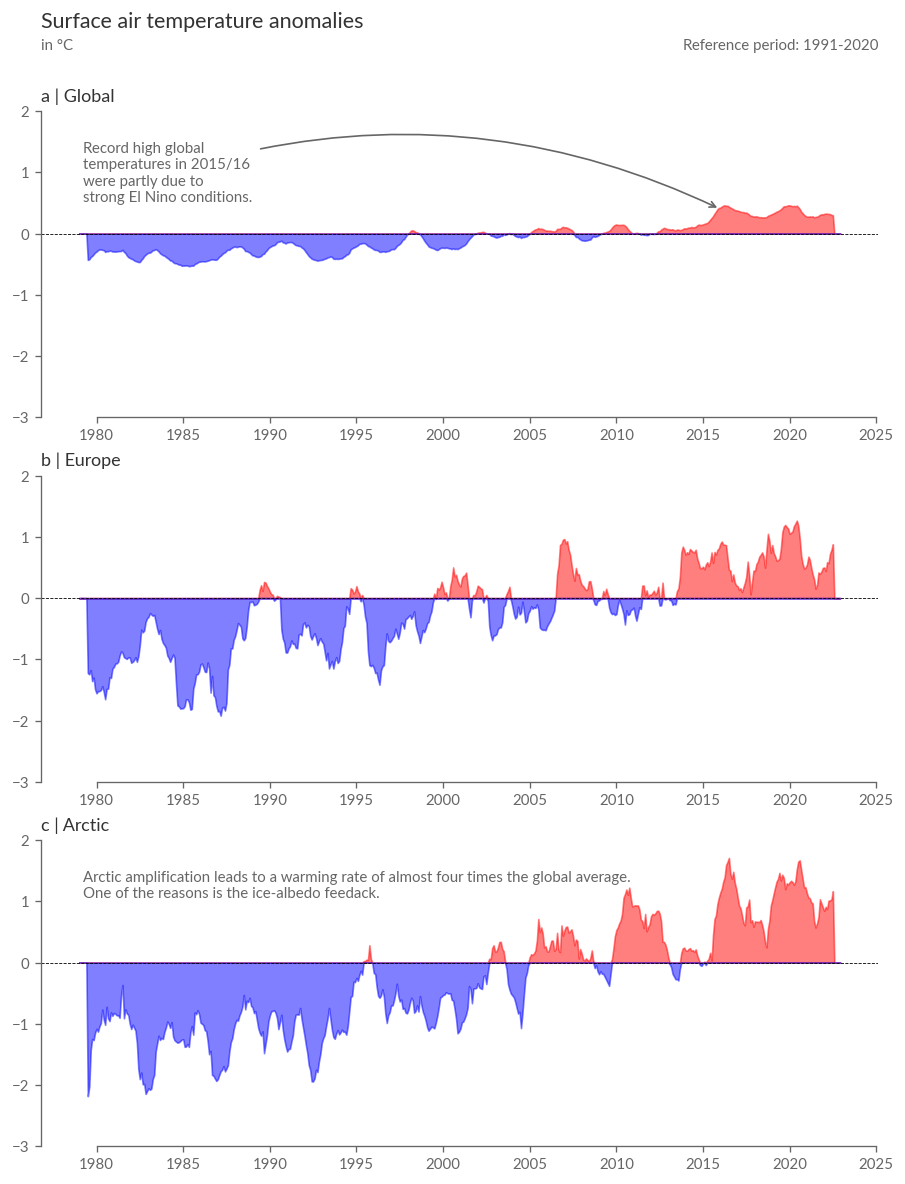

In [15]:
fig = plt.figure(figsize=(9, 12), dpi=120)
gs = GridSpec(4, 1, figure=fig, height_ratios=[0.05, 1, 1, 1], hspace=0.25)

tax = fig.add_subplot(gs[0, 0])
axes = [fig.add_subplot(gs[i, 0]) for i in range(1, 4)]


def add_time_series(da, ax):
    ax.fill_between(
        da.time,
        da.where(da > 0, 0).values,
        color="red",
        alpha=0.5,
    )
    ax.fill_between(
        da.time,
        da.where(da < 0, 0).values,
        color="blue",
        alpha=0.5,
    )


add_time_series(era5_global_mean_smooth, axes[0])
add_time_series(era5_europe_mean_smooth, axes[1])
add_time_series(era5_arctic_mean_smooth, axes[2])

# Add annotations describing the data
desc_global = "Record high global \ntemperatures in 2015/16 \nwere partly due to \nstrong El Nino conditions."
desc_artic = "Arctic amplification leads to a warming rate of almost four times the global average.\nOne of the reasons is the ice-albedo feedack."
axes[0].annotate(
    desc_global,
    xy=(dt.datetime(2016, 1, 1), 0.4),
    xytext=(0.05, 0.9),
    textcoords=axes[0].transAxes,
    ha="left",
    va="top",
    arrowprops=dict(arrowstyle="->", color=".4", connectionstyle="arc3,rad=-0.2"),
)
axes[2].text(0.05, 0.9, desc_artic, transform=axes[2].transAxes, ha="left", va="top")

titles = ["Global", "Europe", "Arctic"]
for i, ax in enumerate(axes):
    ax.set_ylim(-3, 2)
    ax.axhline(0, color="k", ls="--", lw=0.5)
    ax.set_title(f"{ABC[i]} | {titles[i]}")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
tax.axis("off")
tax.set_title("Surface air temperature anomalies", fontsize="x-large")
tax.text(0, 0, "in °C", ha="left", va="bottom", transform=tax.transAxes)
ref_start = REF_PERIOD["time"].start
ref_end = REF_PERIOD["time"].stop
tax.text(
    1,
    0,
    f"Reference period: {ref_start}-{ref_end}",
    ha="right",
    va="bottom",
    transform=tax.transAxes,
)

sns.despine(fig, trim=True)
